In [25]:
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
import featuretools as ft
from sklearn.metrics import make_scorer, mean_absolute_error, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

from sklearn.pipeline import make_union
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate

from category_encoders import OrdinalEncoder, OneHotEncoder, CountEncoder

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from pathlib import Path
import config

sys.path.append('./starspace36_mono_model')
# import starspace_resources as sw_resources

pd.set_option('display.max_rows', 120)
plt.style.use("dark_background")
plt.rcParams['figure.figsize'] = (20, 15)

print(Path.cwd())

/home/sergey/mnt/st1500/Usr/Sergey/TheJob/Otus/ML_advanced2020/home_works/1. Auto_ML/drivendata_flu_shot


In [26]:
X = pd.read_csv("./input/training_set_features.csv", index_col='respondent_id')
y = pd.read_csv("./input/training_set_labels.csv", index_col='respondent_id')
submission_format = pd.read_csv("./input/submission_format.csv", index_col='respondent_id')
test_set = pd.read_csv("./input/test_set_features.csv", index_col='respondent_id')

# X = pd.read_csv("./input/training_set_features.csv")
# y = pd.read_csv("./input/training_set_labels.csv")
# submission_format = pd.read_csv("./input/submission_format.csv")
# test_set = pd.read_csv("./input/test_set_features.csv")

X.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [27]:
X['test'] = False
test_set['test'] = True

X.reset_index(inplace=True, )
test_set.reset_index(inplace=True, )
X_joined = X.append(test_set, ignore_index=True, sort=False)

In [28]:
# split for ordinal values manually, i.e. ages groups
X_joined.replace(to_replace=config.ordinal_to_replace, inplace=True)

numeric = []
for col in config.ordinal:
    num_col = f'{col}_num'
    numeric.append(num_col)
    X_joined[num_col] = X_joined[col]

In [29]:
# Add dataframe to entityset
categorical_ft = dict([col, ft.variable_types.Boolean] for col in config.categorical.keys())
ordinal_ft = dict([col, ft.variable_types.Ordinal] for col in config.ordinal)
numeric_ft = dict([col, ft.variable_types.Numeric] for col in numeric)
variable_dtypes = {**categorical_ft, **ordinal_ft, **numeric_ft}

In [30]:
# Create an entity set
es = ft.EntitySet(id='flu')
es = es.entity_from_dataframe(entity_id='flu',
                              dataframe=X_joined,
                              index='respondent_id',
                              variable_types=variable_dtypes,
                              )

In [31]:
es['flu']

Entity: flu
  Variables:
    respondent_id (dtype: index)
    test (dtype: boolean)
    behavioral_antiviral_meds (dtype: boolean)
    behavioral_avoidance (dtype: boolean)
    behavioral_face_mask (dtype: boolean)
    behavioral_wash_hands (dtype: boolean)
    behavioral_large_gatherings (dtype: boolean)
    behavioral_outside_home (dtype: boolean)
    behavioral_touch_face (dtype: boolean)
    doctor_recc_h1n1 (dtype: boolean)
    doctor_recc_seasonal (dtype: boolean)
    chronic_med_condition (dtype: boolean)
    child_under_6_months (dtype: boolean)
    health_worker (dtype: boolean)
    health_insurance (dtype: boolean)
    race (dtype: boolean)
    sex (dtype: boolean)
    marital_status (dtype: boolean)
    rent_or_own (dtype: boolean)
    employment_status (dtype: boolean)
    hhs_geo_region (dtype: boolean)
    census_msa (dtype: boolean)
    employment_industry (dtype: boolean)
    employment_occupation (dtype: boolean)
    h1n1_concern (dtype: ordinal)
    h1n1_knowledge (dt

In [32]:
ft.list_primitives()

,name,type,dask_compatible,koalas_compatible,description
0,first,aggregation,False,False,Determines the first value in a list.
1,max,aggregation,True,True,"Calculates the highest value, ignoring `NaN` v..."
2,mode,aggregation,False,False,Determines the most commonly repeated value.
3,skew,aggregation,False,False,Computes the extent to which a distribution di...
4,avg_time_between,aggregation,False,False,Computes the average number of seconds between...
5,count,aggregation,True,True,"Determines the total number of values, excludi..."
6,all,aggregation,True,False,Calculates if all values are 'True' in a list.
7,entropy,aggregation,False,False,Calculates the entropy for a categorical variable
8,n_most_common,aggregation,False,False,Determines the `n` most common elements.
9,last,aggregation,False,False,Determines the last value in a list.


In [33]:
# Define which primitives to use
#agg_primitives =  ['count',]
# trans_primitives = ['cum_sum']

agg_primitives =  ['count', 'mean', 'num_unique']
trans_primitives = ['add_numeric']

In [34]:
# Run deep feature synthesis
dfs_feat, dfs_defs = ft.dfs(entityset=es,
                            target_entity='flu',
                            trans_primitives=trans_primitives,
                            agg_primitives=agg_primitives,
                            max_features=1000,
                            chunk_size=4000,
                            verbose=True,
                            max_depth=2,
                            n_jobs=1)


Built 127 features
Elapsed: 00:00 | Progress: 100%|██████████


/home/sergey/anaconda3/envs/ml_advanced_project/lib/python3.8/site-packages/featuretools/synthesis/dfs.py:317: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  agg_primitives: ['count', 'mean', 'num_unique']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


In [35]:
dfs_feat.shape

(53415, 127)

In [36]:
h1n1_train_counts = y.h1n1_vaccine.value_counts()
# h1n1_test_counts = y.h1n1_vaccine.value_counts()

print("соотношения классов h1n1_train_counts \n")
print(f" {h1n1_train_counts.values} {h1n1_train_counts[1] / h1n1_train_counts[0]}")
# print("h1n1_test_counts test \n", h1n1_test_counts.values, h1n1_test_counts[1] / h1n1_test_counts[0])

соотношения классов h1n1_train_counts 

 [21033  5674] 0.26976655731469595


In [37]:
seasonal_train_counts = y.seasonal_vaccine.value_counts()
# h1n1_test_counts = y.h1n1_vaccine.value_counts()

print("соотношения классов seasonal_train_counts \n")
print(f" {seasonal_train_counts.values} {seasonal_train_counts[1] / seasonal_train_counts[0]}")
# print("h1n1_test_counts test \n", h1n1_test_counts.values, h1n1_test_counts[1] / h1n1_test_counts[0])

соотношения классов seasonal_train_counts 

 [14272 12435] 0.8712864349775785


In [38]:
test_set = dfs_feat.loc[dfs_feat.test].copy()
test_set.drop(columns=['test'], inplace=True)
test_set = test_set.astype(config.categorical)

In [39]:
X = dfs_feat.loc[~dfs_feat.test].copy()
X = X.astype(config.categorical)
X.drop(columns=['test'], inplace=True)

In [40]:
X_train, X_val, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

In [41]:
%%time 
print(y.columns)
models = {}
for col in y.columns:
    print('********* Hyperopt main loop', col, '*****************')
    train_set = Pool(data=X_train, label=y_train[col], cat_features=config.categorical.keys())
    val_set = Pool(data=X_val, label=y_test[col], cat_features=config.categorical.keys())

    clf = CatBoostClassifier(**config.params)
    clf.fit(X=train_set, eval_set=val_set, use_best_model=True)

    models[col] = clf
    

Index(['h1n1_vaccine', 'seasonal_vaccine'], dtype='object')
********* Hyperopt main loop h1n1_vaccine *****************
0:	learn: 0.7527700	test: 0.7568663	best: 0.7568663 (0)	total: 56.1ms	remaining: 18m 42s
1000:	learn: 0.9001879	test: 0.8727354	best: 0.8727354 (999)	total: 55.2s	remaining: 17m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8730468084
bestIteration = 1255

Shrink model to first 1256 iterations.
********* Hyperopt main loop seasonal_vaccine *****************
0:	learn: 0.7936984	test: 0.7954134	best: 0.7954134 (0)	total: 73.6ms	remaining: 24m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8630962186
bestIteration = 879

Shrink model to first 880 iterations.
CPU times: user 5min 53s, sys: 1min 44s, total: 7min 37s
Wall time: 2min 10s


h1n1_vaccine
feature_importance < 0.01
h1n1_knowledge 0.0070798956533627295
opinion_h1n1_sick_from_vacc 0.006676249935987625
income_poverty 0.001053611900982914
income_poverty_num 0.0045187764991881626
seasonal_vaccine
feature_importance < 0.01
h1n1_concern 0.0033586862468635618
income_poverty 0.00556523637804358
h1n1_concern_num 0.006392350851328161


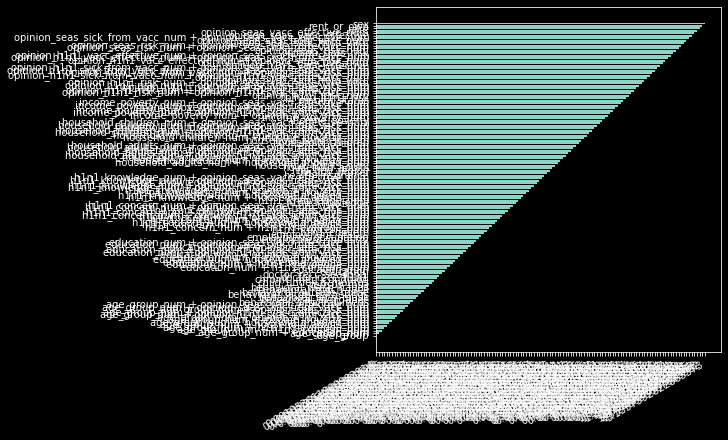

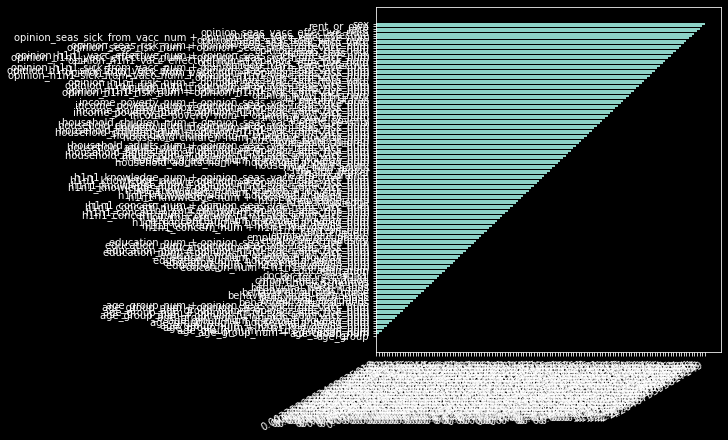

In [42]:
# Графики feature importances

for model_name, model in models.items():
    print(model_name)
    print(model)
    print('feature_importance < 0.01')
    for feature_name, feature_importance in zip(model.feature_names_, model.feature_importances_):
        if feature_importance < 0.01:
            print( feature_name, feature_importance)

    importances_np = np.sort(np.array([model.feature_importances_, model.feature_names_]), axis=1)

    fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True);
    ax.barh(importances_np[1], importances_np[0], align='center');
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right");


In [43]:
print("submission")

submission_df = pd.DataFrame(index=test_set.index)
for col, model in models.items():
    test_pool = Pool(test_set, cat_features=config.categorical.keys())

    # predictions_df = pd.DataFrame(index=test_set.index)
    submission_df[col] = model.predict_proba(test_pool)[:, 1]
            

print("submission_df.shape", submission_df.shape)
print(submission_df.head())

submission
submission_df.shape (26708, 2)
               h1n1_vaccine  seasonal_vaccine
respondent_id                                
26707              0.157846          0.183368
26708              0.038843          0.051173
26709              0.229764          0.710731
26710              0.714678          0.902331
26711              0.362337          0.617235


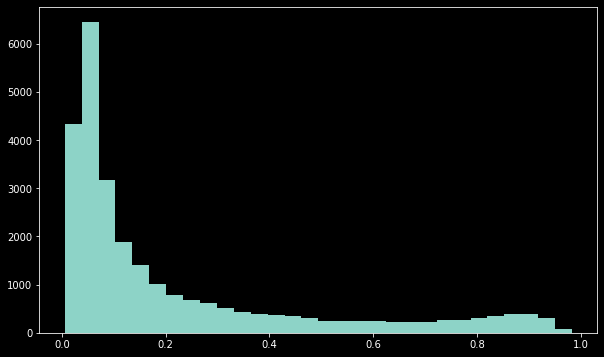

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(submission_df.h1n1_vaccine, bins=30);

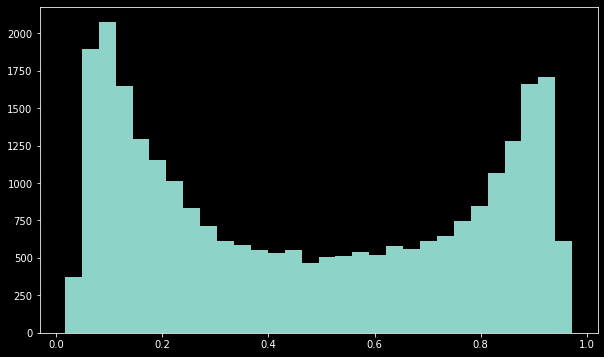

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(submission_df.seasonal_vaccine, bins=30);

In [46]:
submission_df.head(15)

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.157846,0.183368
26708,0.038843,0.051173
26709,0.229764,0.710731
26710,0.714678,0.902331
26711,0.362337,0.617235
26712,0.861485,0.956395
26713,0.298315,0.563801
26714,0.124138,0.104615
26715,0.027477,0.100029


In [47]:
submission_df.to_csv("./flu_submission_noCV.csv")

In [48]:
print('*********   FINISH  ************')






*********   FINISH  ************
